In [ ]:
import os
import pathlib
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
import torch.nn.functional as F
from torch.nn.functional import one_hot
from collections import defaultdict

print(torch.__version__)
#Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

2.0.1+cu118
cuda


In [ ]:
class RMSI(nn.Module):
    def __init__(self, num_classes=11):
        super(RMSI, self).__init__()

        self.num_classes = num_classes
        self.filters = [21, 21, 21, 21, 21, 21, 21, 21]
        self.kernel_size = 128
        self.pool_size = 128
        self.lstm_out_dim = 8
        self.one_hot_size = 21

        self.cnn_layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(self.one_hot_size,
                          out_channels=f,
                          kernel_size=self.kernel_size,
                          stride=1),
                nn.MaxPool1d(self.pool_size)
            ) for f in self.filters
        ])

        self.lstm_layers = nn.ModuleList([nn.LSTM(input_size=f, hidden_size=self.lstm_out_dim) for f in self.filters])

        self.flatten = nn.Flatten()
        self.output_layer = nn.Sequential(
            nn.Linear(self.lstm_out_dim * len(self.filters),
                      self.num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        cnn_outs = [cnn(x) for cnn in self.cnn_layers]
        lstm_outs = [lstm(cnn_out.permute(2, 0, 1))[0][-1, :, :] for lstm, cnn_out in zip(self.lstm_layers, cnn_outs)]  # take output at last timestep only
        concatenated = torch.cat(lstm_outs, dim=1)
        flat_outs = self.flatten(concatenated)
        out = self.output_layer(flat_outs)
        return out


In [ ]:
model_0 = RMSI(num_classes=11)

# assuming you have input data in `inputs`
# and targets in `targets`
inputs = torch.randn(1, 21, 2000)  # batch_size=32, one_hot_size=21, sequence_length=2000
targets = torch.randint(0, 2, (1, 11)).float()  # binary targets for 11 classes for a batch of 32

outputs = model_0(inputs)

In [ ]:
# Install torchinfo if it's not available, import it if it is
#!pip install torchinfo
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary

summary(model_0, input_size=(1, 21, 2000))
# do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
RMSI                                     [1, 11]                   --
├─ModuleList: 1-1                        --                        --
│    └─Sequential: 2-1                   [1, 21, 14]               --
│    │    └─Conv1d: 3-1                  [1, 21, 1873]             56,469
│    │    └─MaxPool1d: 3-2               [1, 21, 14]               --
│    └─Sequential: 2-2                   [1, 21, 14]               --
│    │    └─Conv1d: 3-3                  [1, 21, 1873]             56,469
│    │    └─MaxPool1d: 3-4               [1, 21, 14]               --
│    └─Sequential: 2-3                   [1, 21, 14]               --
│    │    └─Conv1d: 3-5                  [1, 21, 1873]             56,469
│    │    └─MaxPool1d: 3-6               [1, 21, 14]               --
│    └─Sequential: 2-4                   [1, 21, 14]               --
│    │    └─Conv1d: 3-7                  [1, 21, 1873]             56,469

In [ ]:
# Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Now, load the model (change '/content/gdrive/My Drive/modelname.path' to the path where you saved your model)
model_0.load_state_dict(torch.load('/content/gdrive/My Drive/RMSI_model_1.pth'))


Mounted at /content/gdrive


<All keys matched successfully>

In [ ]:
#Setup path to a data folder
import zipfile
from pathlib import Path

data_path = Path("custom_test_data/")
text_path = data_path / "RMS"

if text_path.is_dir():
  print(f"{text_path} directory already exists.. skipping extraction")
else:
  print(f"{text_path} does not exist, creating one...")
  text_path.mkdir(parents=True, exist_ok=True)

# File path in Google Colab after upload
zip_path = Path("custom_test_data/RMS/A._ferrooxidans_proteins.zip")  # Update this if your file is in a different location

#Unzip the data
with zipfile.ZipFile(zip_path, "r") as zip_ref:
  print(f"Unzipping file...")
  zip_ref.extractall(text_path)


custom_test_data/RMS directory already exists.. skipping extraction
Unzipping file...


In [ ]:
#!rm -r test_prot_set2

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} sequences in '{dirpath}'.")

walk_through_dir(text_path)

There are 1 directories and 1 sequences in 'custom_test_data/RMS'.
There are 0 directories and 3147 sequences in 'custom_test_data/RMS/A._ferrooxidans_proteins'.


In [ ]:
test_dir = text_path / "A._ferrooxidans_proteins"
test_dir

PosixPath('custom_test_data/RMS/A._ferrooxidans_proteins')

In [ ]:
from torch.nn.functional import one_hot
from torch.utils.data import Dataset
import os
import torch
from collections import defaultdict

# Define a index encoding for the amino acid sequences
amino_acids = ['A', 'C', 'D', 'E', 'F',
               'G', 'H', 'I', 'K', 'L',
               'M', 'N', 'P', 'Q', 'R',
               'S', 'T', 'V', 'W', 'Y', '0']
amino_to_index = {aa: index for index, aa in enumerate(amino_acids)}

class AminoAcidSequenceDataset(Dataset):
    def __init__(self, root_dir, classes):
        self.classes = classes # get list of classes
        # Create a mapping of class names to integers
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.files = []
        self.labels = []
        self.max_length = 0

        # loop through each class's directory, then each file in that directory
        for label, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for filename in os.listdir(class_dir):
                file_path = os.path.join(class_dir, filename)
                self.files.append(file_path)
                # Use the mapping to convert class names to integers
                self.labels.append(self.class_to_idx[class_name])

                # open the file and find its length
                with open(file_path, 'r') as f:
                    sequence = f.read().strip()
                    self.max_length = max(self.max_length, len(sequence))

        # Print the lengths of self.files and self.labels
        print(f"Length of self.files: {len(self.files)}")
        print(f"Length of self.labels: {len(self.labels)}")

    def __len__(self):
      return len(self.files)

    def __getitem__(self, idx):
        with open(self.files[idx], 'r') as f:
            sequence = f.read().strip()

        sequence = sequence.ljust(2000, '0')

        amino_to_index_default = defaultdict(lambda: amino_to_index['0'])
        amino_to_index_default.update(amino_to_index)
        index_sequence = [amino_to_index_default[aa] for aa in sequence]

        # Convert indices to one-hot encoded tensor
        sequence_tensor = torch.nn.functional.one_hot(torch.tensor(index_sequence, dtype=torch.long),
                                                      num_classes=len(amino_to_index))

        return sequence_tensor.float().to(device), self.labels[idx]

# Specify the order of classes
classes = ['Type_III_restriction_enzyme',
           'Type_II_restriction_enzyme',
           'Type_II_methyltransferase',
           'Type_III_methyltransferase',
           'Type_IIG_restriction_enzyme_methyltransferase',
           'Type_IV_methyl-directed_restriction_enzyme',
           'Type_II_specificity_subunit',
           'Type_I_restriction_enzyme',
           'Type_I_specificity_subunit',
           'negatives',
           'Type_I_methyltransferase']

# Create your datasets
test_data = AminoAcidSequenceDataset(root_dir=test_dir, classes=classes)

# Get the first item in the dataset
first_item, first_label = test_data[0]

# Print its shape
print(first_item.shape)

FileNotFoundError: ignored

In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 1024
NUM_WORKERS = 0

print(f"Length of test_data before creating DataLoader: {len(test_data)}")
testing_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

testing_dataloader


Length of test_data before creating DataLoader: 571458


In [ ]:
# Get class names as a list
#CHeck the lengths of our dataset
print(len(test_data))
class_dict = test_data.class_to_idx
# Remove .ipynb_checkpoints
if '.ipynb_checkpoints' in class_dict:
    del class_dict['.ipynb_checkpoints']
class_dict

571458


{'Type_III_restriction_enzyme': 0,
 'Type_II_restriction_enzyme': 1,
 'Type_II_methyltransferase': 2,
 'Type_III_methyltransferase': 3,
 'Type_IIG_restriction_enzyme_methyltransferase': 4,
 'Type_IV_methyl-directed_restriction_enzyme': 5,
 'Type_II_specificity_subunit': 6,
 'Type_I_restriction_enzyme': 7,
 'Type_I_specificity_subunit': 8,
 'negatives': 9,
 'Type_I_methyltransferase': 10}

In [ ]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")#

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.9 MB/s eta 0:00:00
mlxtend version: 0.22.0


Making predictions...:   0%|          | 0/559 [00:00<?, ?it/s]

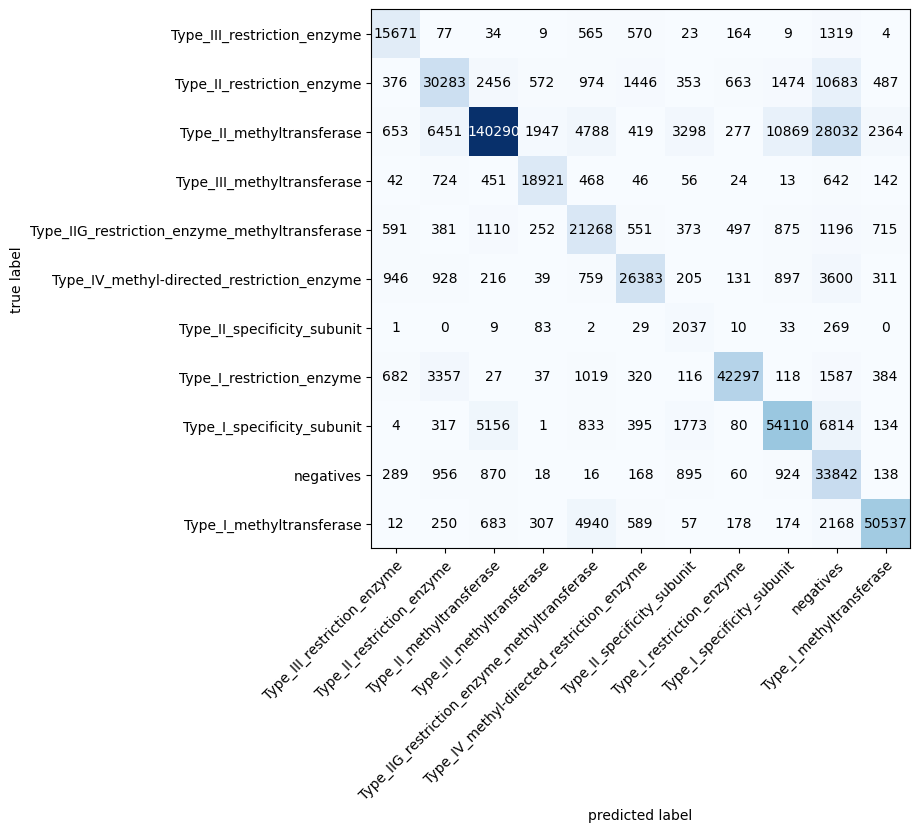

In [ ]:
from torchmetrics import ConfusionMatrix
from tqdm.auto import tqdm
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
import torch

# Function to make predictions with the model
def make_predictions(model, dataloader, device):
    model_0.eval()
    y_preds = []
    y_trues = []
    with torch.inference_mode():
        for X, y in tqdm(dataloader, desc="Making predictions..."):
            X, y = X.to(device), y.to(device)
            X = X.permute(0, 2, 1)
            y_logit = model(X)
            y_pred = torch.softmax(y_logit, dim=0).argmax(dim=1)
            y_preds.append(y_pred.cpu())
            y_trues.append(y.cpu())
    return torch.cat(y_preds), torch.cat(y_trues)

# Function to calculate and plot confusion matrix
def plot_conf_mat(y_preds, y_true, class_dict):
    confumat = ConfusionMatrix(num_classes=len(class_dict), task='multiclass')
    confumat.update(preds=y_preds, target=y_true)

    confumat_tensor = confumat.compute().cpu()

    fig, ax = plot_confusion_matrix(
        conf_mat=confumat_tensor.numpy(),
        class_names=[key for key in sorted(class_dict.keys(), key=lambda x: class_dict[x])],
        figsize=(10, 7)
    )
    plt.show()

# Generate predictions
y_pred_tensor, y_targets_tensor = make_predictions(model_0, testing_dataloader, device)

# Calculate and plot the confusion matrix
plot_conf_mat(y_pred_tensor, y_targets_tensor, class_dict)


In [ ]:
# Print Classification report
print(classification_report(y_targets_tensor.numpy(), y_pred_tensor.numpy()))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83     18445
           1       0.69      0.61      0.65     49767
           2       0.93      0.70      0.80    199388
           3       0.85      0.88      0.87     21529
           4       0.60      0.76      0.67     27809
           5       0.85      0.77      0.81     34415
           6       0.22      0.82      0.35      2473
           7       0.95      0.85      0.90     49944
           8       0.78      0.78      0.78     69617
           9       0.38      0.89      0.53     38176
          10       0.92      0.84      0.88     59895

    accuracy                           0.76    571458
   macro avg       0.73      0.80      0.73    571458
weighted avg       0.82      0.76      0.78    571458



In [ ]:
print('Number of test examples:', len(test_data))
print('Number of predictions:', y_pred_tensor.shape[0])
print(y_pred_tensor.shape)
print(torch.tensor(test_data.labels).shape)
print(y_pred_tensor.min(), y_pred_tensor.max())
print(torch.tensor(test_data.labels).min(), torch.tensor(test_data.labels).max())


Number of test examples: 571458
Number of predictions: 571458
torch.Size([571458])
torch.Size([571458])
tensor(0) tensor(10)
tensor(0) tensor(10)


In [ ]:
!pip install keras

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F

model_0 = model_0.to(device)
# Set model to evaluation mode
model_0.eval()

# Define the amino acids and their corresponding one-hot encodings
amino_acids = {aa: i for i, aa in enumerate('ACDEFGHIKLMNPQRSTVWY0')}

# Amino acid sequence
sequence = "MNLDATRESIFQNDIIQQMLAQGWQLGTPQGYNRESALYEQDVLDFVQQTQSQDWQKFQRIFPQGTEGHFLEAVVAQLKKADINATDEQSRSYGTLGVLRHGVKTRSARFFLCQFKPEHALNPDTLANYKKNICRIVPELVYSPYATAAELQDMGKQAKKWRIDLVLFINGFPVATLELKSEFKQAVQNAMLQYKRTRLPKDPETNKPEPLLMFKRGALVHFAVSQYEVYMATQLAGEDTFFLPFNKGTHDGGAGNDVPEDQNQYATAYLWNEVLTPDNLLNIIGRFVHLQIEEKEDWEGRKYKKELLIFPRYHQWNVVTKLINAALEEGTGQKYLIQHSAGSGKSNSIAWTAHQLSTLYDQHNQKLFDSVIVVTDRTILDAQLQDTIYQFEHADGVVGRINNKEGDGSKSEKLAKALETSQPIIIVTIQTFPFVLRAIENSTNLKQRRYAVIADEAHSSQSGSTARQLKEVLMLEEREEDAELSSEDILDAVVAARKGSNNLSYYAFTATPKDKTLQLFGRVPNPELPPSKQNKPEAFHVYSMRQAIEEGFILDVLKNYTNYKVVYKLKQKIEEADKQVDAKKAKIRLNQWVRLHDHNISQKVKVIVEHFKNNVMGLLGGQAKAMVVTSSRKEAVRYKLAFDKYVADQGYKSIQAMVAFSGEVEFNDKDTDSSGLVGQTFNERNMNPGLKGREMRKAFDSDDYQVMLVANKFQTGFDQPKLCAMYVDKKLGGVECVQTLSRLNRTYPGKAESGTFVLDFFNDPEDILGAFQPYYQTAELADVSNPDQIFDLFEKLKASKIFLWTEVEQFVEAFFTKNKSNAAISNICKPAVERWQKRYSQAIEAYNTSRDMLERCKKTNDAVLIANADNAFKEAKLEKDKLEIFKKDLGSFTRFYEFMSQIVDYDDKELEKLSLYARNLRPLLRETATKDDEVDLSNVSMSHYRLSKIRQQDIKLKEDAEDFKLEPGNDLGAAKPRDKKEEFLSQIIERLNDVFITDNLTDKDMLNYAYTVRDKLAENEIVMKQIANNTREQAMLGDFPKAMDDAILGSSAAHQEQMMQLLSDPAKASIFARVIFDMLISPR"

# Convert the sequence to encoded format
sequence_encoded = [amino_acids[aa] for aa in sequence]

# One-hot encoding
sequence_one_hot = F.one_hot(torch.tensor(sequence_encoded), num_classes=21)

# Pad the sequence to length of 2000
pad_size = 2000 - len(sequence_encoded)
if pad_size > 0:
    sequence_padded = F.pad(sequence_one_hot.float(), (0, 0, 0, pad_size))
else:
    sequence_padded = sequence_one_hot[:2000].float()

# Add the batch dimension
sequence_tensor = sequence_padded.unsqueeze(0).transpose(-1, -2).to(device)

# Make the model prediction
with torch.inference_mode():
    output = model_0(sequence_tensor)

output_probs = torch.softmax(output, dim=1).cpu().detach().numpy()

# Dictionary to map index to class label
class_labels = {
    0: 'Type_III_restriction_enzyme',
    1: 'Type_II_restriction_enzyme',
    2: 'Type_II_methyltransferase',
    3: 'Type_III_methyltransferase',
    4: 'Type_IIG_restriction_enzyme_methyltransferase',
    5: 'Type_IV_methyl-directed_restriction_enzyme',
    6: 'Type_II_specificity_subunit',
    7: 'Type_I_restriction_enzyme',
    8: 'Type_I_specificity_subunit',
    9: 'negatives',
    10: 'Type_I_methyltransferase'
}

# Print the logits as percents
max_prob = -np.inf
max_class = None

for i, prob in enumerate(output_probs[0]):
    if prob > max_prob:
        max_prob = prob
        max_class = i
    class_label = class_labels[i]
    print(f"{class_label:<45} {prob*100:.2f}%")

print("\nHighest class:")
print(f"{class_labels[max_class]} with probability of {max_prob*100:.2f}%")


Type_III_restriction_enzyme                   8.26%
Type_II_restriction_enzyme                    8.90%
Type_II_methyltransferase                     7.76%
Type_III_methyltransferase                    7.70%
Type_IIG_restriction_enzyme_methyltransferase 10.90%
Type_IV_methyl-directed_restriction_enzyme    7.46%
Type_II_specificity_subunit                   7.82%
Type_I_restriction_enzyme                     15.76%
Type_I_specificity_subunit                    8.51%
negatives                                     8.60%
Type_I_methyltransferase                      8.32%

Highest class:
Type_I_restriction_enzyme with probability of 15.76%
